In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We’ll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count to use to later replace rare words.

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the reverse flag to reverse the pairs.

In [4]:

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    
    # datafolder
    datafolder = '/home/jithin/datasets/seq2seq/'
    # Read the file and split into lines
    lines = open(datafolder+'data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['tu es fort sage .', 'you re very wise .']


In [7]:
pairs

[['j ai ans .', 'i m .'],
 ['je vais bien .', 'i m ok .'],
 ['ca va .', 'i m ok .'],
 ['je suis gras .', 'i m fat .'],
 ['je suis gros .', 'i m fat .'],
 ['je suis en forme .', 'i m fit .'],
 ['je suis touche !', 'i m hit !'],
 ['je suis touchee !', 'i m hit !'],
 ['je suis malade .', 'i m ill .'],
 ['je suis triste .', 'i m sad .'],
 ['je suis timide .', 'i m shy .'],
 ['je suis mouille .', 'i m wet .'],
 ['je suis mouillee .', 'i m wet .'],
 ['il est mouille .', 'he s wet .'],
 ['je suis gras .', 'i am fat .'],
 ['je suis revenu .', 'i m back .'],
 ['me revoila .', 'i m back .'],
 ['je suis chauve .', 'i m bald .'],
 ['je suis occupe .', 'i m busy .'],
 ['je suis occupee .', 'i m busy .'],
 ['je suis calme .', 'i m calm .'],
 ['j ai froid .', 'i m cold .'],
 ['j en ai fini .', 'i m done .'],
 ['tout va bien .', 'i m fine .'],
 ['je vais bien .', 'i m fine .'],
 ['ca va .', 'i m fine .'],
 ['je suis libre !', 'i m free !'],
 ['je suis libre .', 'i m free .'],
 ['je suis disponible .',

# Encoder Model
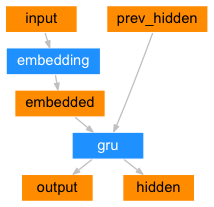

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
model = EncoderRNN(2,2)
model

EncoderRNN(
  (embedding): Embedding(2, 2)
  (gru): GRU(2, 2)
)

# Decoder RNN
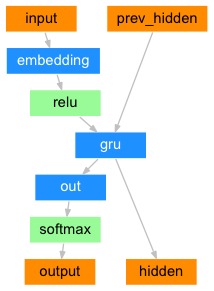

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
model = DecoderRNN(2, 3)
model

DecoderRNN(
  (embedding): Embedding(3, 2)
  (gru): GRU(2, 2)
  (out): Linear(in_features=2, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

# Decoder model with Attention
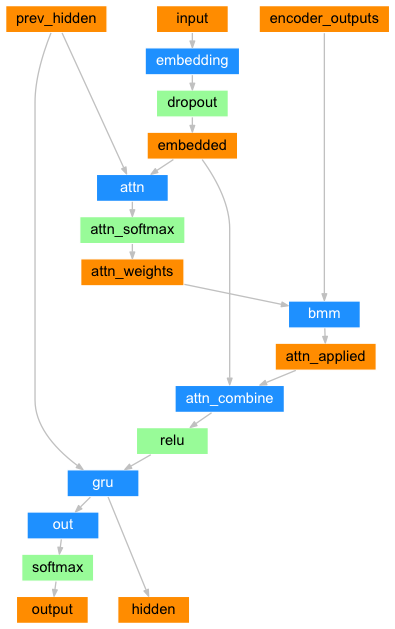

In [17]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
model = AttnDecoderRNN(2, 2, max_length=3)
model

AttnDecoderRNN(
  (embedding): Embedding(2, 2)
  (attn): Linear(in_features=4, out_features=3, bias=True)
  (attn_combine): Linear(in_features=4, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(2, 2)
  (out): Linear(in_features=2, out_features=2, bias=True)
)

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [25]:
teacher_forcing_ratio = 0.5
from IPython.core.debugger import set_trace

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    #### DEBUGGING ####
    #set_trace()

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()


    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        ########
        break
        
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [14]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [28]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        #decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            #decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [29]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [26]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
#attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
attn_decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

8m 32s (- 119m 31s) (5000 6%) 2.9048
11m 15s (- 73m 13s) (10000 13%) 2.3496
14m 8s (- 56m 34s) (15000 20%) 2.0403
17m 0s (- 46m 45s) (20000 26%) 1.7939
19m 55s (- 39m 51s) (25000 33%) 1.5856
22m 51s (- 34m 16s) (30000 40%) 1.4304
25m 39s (- 29m 19s) (35000 46%) 1.2853
28m 31s (- 24m 57s) (40000 53%) 1.1261
31m 29s (- 20m 59s) (45000 60%) 1.0145
34m 23s (- 17m 11s) (50000 66%) 0.9298
37m 17s (- 13m 33s) (55000 73%) 0.8255
40m 14s (- 10m 3s) (60000 80%) 0.7165
43m 10s (- 6m 38s) (65000 86%) 0.6653
46m 1s (- 3m 17s) (70000 93%) 0.5886
48m 48s (- 0m 0s) (75000 100%) 0.5331


In [19]:
evaluateRandomly(encoder1, attn_decoder1)


> vous etes tres religieux n est ce pas ?
= you re very religious aren t you ?
< you re very religious aren t you ? <EOS>

> il est en train de dessiner une image .
= he is drawing a picture .
< he is drawing a picture . <EOS>

> je me rejouis que vous soyez mon ami .
= i m glad you re my friend .
< i m glad you re my friend . <EOS>

> tu es completement ignorant .
= you re totally ignorant .
< you re totally ignorant . <EOS>

> je ne suis pas une commere .
= i m not one to gossip .
< i m not a professional . <EOS>

> je suis plus que content .
= i m more than happy .
< i m more than happy . <EOS>

> je suis heureux avec ce que j ai .
= i m happy with what i ve got .
< i m happy with what i ve got . <EOS>

> il est auteur .
= he s an author .
< he is an author . <EOS>

> je vais acheter du pain .
= i m going to buy some bread .
< i m going to buy some bread . <EOS>

> nous sommes les meilleurs .
= we are the best .
< we re the best . <EOS>



In [30]:
# using no attention
evaluateRandomly(encoder1, attn_decoder1)


> je suis desolee mon pere est elimine .
= i m sorry my father is out .
< i m sorry my father is out . <EOS>

> je suis desole de vous avoir derangees !
= i m sorry to have bothered you .
< i m sorry to have bothered you . <EOS>

> c est la chouchoute de la prof .
= she s the teacher s pet .
< she s the teacher s pet . <EOS>

> je ne suis plus votre mari .
= i m not your husband anymore .
< i m not your husband anymore . <EOS>

> je suis presque pret .
= i m about ready .
< i m about ready . <EOS>

> je suis ponctuelle .
= i m punctual .
< i m punctual . <EOS>

> je creve de froid .
= i m freezing cold .
< i m cold cold . <EOS>

> il est encore au travail .
= he s still at work .
< he is still at work . <EOS>

> il vient de sortir de l universite .
= he s fresh out of college .
< he is fresh out from college . <EOS>

> je suis celui qui a construit ceci .
= i m the one who built this .
< i m the one who built this . <EOS>

